In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "/home/srs-9/Projects/ms_mri/analysis/thalamus/helpers")
from scipy.stats import pearsonr
import helpers
import utils
import json

In [14]:
max_dzdur = None

hips_thomas_ref = pd.read_csv(
    "/home/srs-9/Projects/ms_mri/data/hipsthomas_struct_index.csv", index_col="index"
)["struct"]
thalamic_nuclei = [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

# Load longitudinal volumes
df_long = pd.read_csv("/home/srs-9/Projects/ms_mri/longitudinal_pipeline/data0/full_volumes.csv")
df_long['time1'] = pd.to_datetime(df_long['time1'], format='%Y%m%d')
df_long['time2'] = pd.to_datetime(df_long['time2'], format='%Y%m%d')
df_long['interval_years'] = (df_long['time2'] - df_long['time1']).dt.days / 365.25

df_long2 = pd.read_csv("/home/srs-9/Projects/ms_mri/longitudinal_pipeline/data0/full_volumes_thalamus.csv")
df_long2['time1'] = pd.to_datetime(df_long2['time1'], format='%Y%m%d')
df_long2['time2'] = pd.to_datetime(df_long2['time2'], format='%Y%m%d')
df_long2['interval_years'] = (df_long2['time2'] - df_long2['time1']).dt.days / 365.25

df_long3 = pd.read_csv("/home/srs-9/Projects/ms_mri/longitudinal_pipeline/data0/deformation_data.csv")
df_long3['time1'] = pd.to_datetime(df_long3['time1'], format='%Y%m%d')
df_long3['time2'] = pd.to_datetime(df_long3['time2'], format='%Y%m%d')
df_long3['interval_years'] = (df_long3['time2'] - df_long3['time1']).dt.days / 365.25

groups = {
    "medial": ["MD_Pf_12", "CM_11"],
    "ventral": ["VA_4", "VLa_5", "VLP_6", "VPL_7"],
    "posterior": ["Pul_8", "MGN_10", "LGN_9"],
    "anterior": ["AV_2"]
}
for group, nucs in groups.items():
    cols = [f"{nuc}_time1" for nuc in nucs]
    df_long[f"{group}_time1"] = df_long[cols].sum(axis=1)
    cols = [f"{nuc}_time2" for nuc in nucs]
    df_long[f"{group}_time2"] = df_long[cols].sum(axis=1)


cols_ordered = ["subid", "interval_years", "time1", "time2"]
for struct in hips_thomas_ref.to_list() + list(groups.keys()):
    cols_ordered.extend([f"{struct}_time1", f"{struct}_time2"])
df_long = df_long[cols_ordered]
df_long3 = df_long3[cols_ordered]


# Load baseline covariates (adjust path as needed)
# Expected columns: subid, T2LV, dzdur, age, Female, tiv, CP
df_base = utils.load_data("/home/srs-9/Projects/ms_mri/analysis/thalamus/results/data_wchaco.csv")
df_base = df_base.reset_index()

# Merge on subid
df1 = df_long.merge(df_base, on='subid', how='inner')
df1['thalamus_time1'] = df_long2['thalamus_time1']
df1['thalamus_time2'] = df_long2['thalamus_time2']

df2 = df_long3.merge(df_base, on='subid', how='inner')


# skip_subs = [1027, 1264, 1163]
# df = df[~df['subid'].isin(skip_subs)]

df = df2
df = df[df['dz_type3'] == "MS"]


if max_dzdur is not None:
    df = df[df['dzdur'] < max_dzdur]
    print(f"N after dzdur<{max_dzdur}: {len(df)}")
    print(f"Interval range: {df['interval_years'].min():.2f} – {df['interval_years'].max():.2f} years")
    
print(f"N: {len(df)}")
print(f"Interval range: {df['interval_years'].min():.2f} – {df['interval_years'].max():.2f} years")



N: 186
Interval range: 3.02 – 5.42 years


### compute annualized change scores
Using annualized % change to account for variable follow-up intervals.
Annualized % = ((V2 - V1) / V1) / interval * 100
This is our primary longitudinal outcome.

In [19]:
structures = {
    hips_thomas_ref[i]: hips_thomas_ref[i] for i in thalamic_nuclei
}
structures.update({group: group for group in groups})
# structures.update({"thalamus": "thalamus"})

for col_prefix, label in structures.items():
    v1 = df[f'{col_prefix}_time1']
    v2 = df[f'{col_prefix}_time2']
    pct_change = (v2 - v1) / v1 * 100
    abs_change = v2 - v1
    df[f'{col_prefix}_pct_change'] = pct_change
    df[f'{col_prefix}_abs_change'] = abs_change
    df[f'{col_prefix}_ann_pct_change'] = pct_change / df['interval_years']
    df[f'{col_prefix}_ann_abs_change'] = abs_change / df['interval_years']
    df_long[f'{col_prefix}_pct_change'] = pct_change
    df_long[f'{col_prefix}_ann_pct_change'] = pct_change / df_long['interval_years']
    df_long[f'{col_prefix}_abs_change'] = abs_change
    df_long[f'{col_prefix}_ann_abs_change'] = abs_change / df_long['interval_years']

print(df[[f'{col_prefix}_ann_pct_change' for col_prefix in structures]].describe().round(3))


       THALAMUS_1_ann_pct_change  AV_2_ann_pct_change  VA_4_ann_pct_change  \
count                    184.000              182.000              184.000   
mean                      -0.320                0.031               -0.335   
std                        1.026                1.978                1.661   
min                       -3.401               -3.704               -4.522   
25%                       -0.846               -1.153               -1.478   
50%                       -0.447               -0.249               -0.396   
75%                       -0.024                0.998                0.705   
max                        4.804               12.061                3.970   

       VLa_5_ann_pct_change  VLP_6_ann_pct_change  VPL_7_ann_pct_change  \
count               183.000               184.000               184.000   
mean                 -0.301                -0.655                -0.639   
std                   2.494                 1.711                 1.984 

(array([ 8., 12., 27., 56., 45., 15., 14.,  2.,  4.,  1.]),
 array([-4.6152816 , -3.36447294, -2.11366428, -0.86285562,  0.38795305,
         1.63876171,  2.88957037,  4.14037903,  5.39118769,  6.64199635,
         7.89280501]),
 <BarContainer object of 10 artists>)

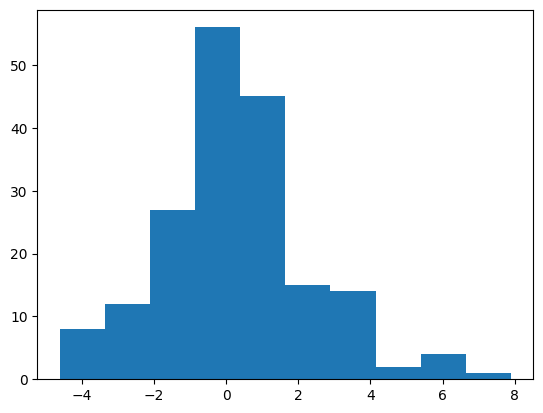

In [20]:
plt.hist(df['MD_Pf_12_ann_pct_change'])

In [22]:

# THAL_MIN, THAL_MAX = 5500, 13000
# THAL_MIN, THAL_MAX = 4000, 13000
THAL_MIN, THAL_MAX = 0, 13000
ANN_CHANGE_THRESH = 5  # % per year — biologically implausible

df['qc_thal_t1_range'] = df['THALAMUS_1_time1'].between(THAL_MIN, THAL_MAX)
df['qc_thal_t2_range'] = df['THALAMUS_1_time2'].between(THAL_MIN, THAL_MAX)
df['qc_ann_change']    = df['THALAMUS_1_ann_pct_change'].abs() < ANN_CHANGE_THRESH
df['qc_pass']          = df['qc_thal_t1_range'] & df['qc_thal_t2_range'] & df['qc_ann_change']

print(f"\nQC summary:")
print(f"  Fail thal range at T1:    {(~df['qc_thal_t1_range']).sum()}")
print(f"  Fail thal range at T2:    {(~df['qc_thal_t2_range']).sum()}")
print(f"  Fail ann change threshold:{(~df['qc_ann_change']).sum()}")
print(f"  Total QC pass:            {df['qc_pass'].sum()} / {len(df)}")

# Inspect failures
df_fail = df[~df['qc_pass']][['subid', 'interval_years',
                               'THALAMUS_1_time1', 'THALAMUS_1_time2',
                               'THALAMUS_1_pct_change', 'THALAMUS_1_ann_pct_change']]
print("\nFailed subjects:")
print(df_fail.to_string())

df_qc = df[df['qc_pass']].copy()
print(f"\nProceeding with N={len(df_qc)} after QC")



QC summary:
  Fail thal range at T1:    2
  Fail thal range at T2:    2
  Fail ann change threshold:2
  Total QC pass:            184 / 186

Failed subjects:
     subid  interval_years  THALAMUS_1_time1  THALAMUS_1_time2  THALAMUS_1_pct_change  THALAMUS_1_ann_pct_change
17    1053        4.514716               NaN               NaN                    NaN                        NaN
140   2003        4.125941               NaN               NaN                    NaN                        NaN

Proceeding with N=184 after QC


In [42]:
df.sort_values(by="MD_Pf_12_ann_pct_change", ascending=False)[['subid', 'THALAMUS_1_ann_pct_change', 'MD_Pf_12_ann_pct_change']]

,subid,THALAMUS_1_ann_pct_change,MD_Pf_12_ann_pct_change
1,1003,4.803873,7.892805
18,1054,-0.590925,6.420595
139,1546,0.052350,6.262470
55,1182,3.746535,5.901690
37,1130,0.375514,5.409004
...,...,...,...
166,2120,-0.361448,-3.928085
75,1246,-3.401444,-3.984125
51,1165,-1.487469,-4.615282
17,1053,NaN,NaN


In [38]:
check_df = df[~df['THALAMUS_1_ann_pct_change'].isna()]
pearsonr(check_df['THALAMUS_1_ann_pct_change'], check_df['Pul_8_ann_pct_change'])

PearsonRResult(statistic=np.float64(0.899319541270998), pvalue=np.float64(2.7369741660176003e-67))

In [35]:
df.isna()

,subid,interval_years,time1,time2,THALAMUS_1_time1,THALAMUS_1_time2,AV_2_time1,AV_2_time2,VA_4_time1,VA_4_time2,...,posterior_ann_pct_change,posterior_ann_abs_change,anterior_pct_change,anterior_abs_change,anterior_ann_pct_change,anterior_ann_abs_change,qc_thal_t1_range,qc_thal_t2_range,qc_ann_change,qc_pass
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
182,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
183,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
184,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [23]:
print("One-sample t-tests (H0: no change):")
print(f"{'Structure':<25} {'Mean %/yr':>10} {'t':>8} {'p':>8}")
print("-" * 55)
for key, label in structures.items():
    vals = df_qc[f'{key}_ann_pct_change'].dropna()
    t, p = stats.ttest_1samp(vals, 0)
    print(f"{label:<25} {vals.mean():>10.3f} {t:>8.3f} {p:>8.4f}")


One-sample t-tests (H0: no change):
Structure                  Mean %/yr        t        p
-------------------------------------------------------
THALAMUS_1                    -0.320   -4.237   0.0000
AV_2                           0.031    0.213   0.8319
VA_4                          -0.335   -2.738   0.0068
VLa_5                         -0.301   -1.632   0.1045
VLP_6                         -0.655   -5.192   0.0000
VPL_7                         -0.639   -4.372   0.0000
Pul_8                         -0.560   -4.723   0.0000
LGN_9                         -0.658   -4.154   0.0001
MGN_10                        -0.483   -3.992   0.0001
CM_11                          0.073    0.401   0.6891
MD_Pf_12                       0.295    1.873   0.0627
Hb_13                          0.616    3.419   0.0008
medial                         0.271    1.772   0.0780
ventral                       -0.581   -5.502   0.0000
posterior                     -0.557   -5.001   0.0000
anterior                    

In [26]:
df_qc_z = utils.zscore(df_qc)
struct = "THALAMUS_1"
res = smf.ols(f"{struct}_ann_abs_change ~ age + Female + tiv + dzdur", data=df_qc_z).fit()
print(res.summary())

                                OLS Regression Results                               
Dep. Variable:     THALAMUS_1_ann_abs_change   R-squared:                       0.024
Model:                                   OLS   Adj. R-squared:                  0.002
Method:                        Least Squares   F-statistic:                     1.112
Date:                       Sat, 28 Feb 2026   Prob (F-statistic):              0.352
Time:                               03:55:05   Log-Likelihood:                -258.83
No. Observations:                        184   AIC:                             527.7
Df Residuals:                            179   BIC:                             543.7
Df Model:                                  4                                         
Covariance Type:                   nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------